### Toxic Comment Classification Challenge
- 위협, 외설, 모욕 및 증오와 같은 다양한 유형의 Toxic를 분류하는 모델
- keras LSTM을 활용한 Classification 문제 해결
- Wikipedia’s talk page edits dataset 사용
- Submissions 평가 기준 ROC AUC.
  - 각 예측 열의 개별 AUC 평균

# 라이브러리 및 패키지

In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

In [2]:
train = pd.read_csv('C:\\Coding\\Kaggle_data\\Tackling-toxic-using-keras\\train.csv')
test = pd.read_csv('C:\\Coding\\Kaggle_data\\Tackling-toxic-using-keras\\test.csv')

In [13]:
train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


- comment_text : text
- toxic : toxic
- severe_toxic : 심각한 toxic
- obscene : 음란
- threat : 위협
- insult : 모욕
- identity_hate : 정체성 혐오

null값 확인(없애거나 채우기) 

In [8]:
print(train.isnull().any()) # null(=nan)
print('-'*30)
print(test.isnull().any())

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool
------------------------------
id              False
comment_text    False
dtype: bool


In [45]:
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


Feature Engneering에 집중하지 않고 최소한의 작업으로 진행할 예정

종속변수(Y)는 train set 자체에 있으므로 X 및 Y 세트로 분할

In [9]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

y = train[list_classes].values

list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [12]:
list_sentences_train

0         Explanation\nWhy the edits made under my usern...
1         D'aww! He matches this background colour I'm s...
2         Hey man, I'm really not trying to edit war. It...
3         "\nMore\nI can't make any real suggestions on ...
4         You, sir, are my hero. Any chance you remember...
                                ...                        
159566    ":::::And for the second time of asking, when ...
159567    You should be ashamed of yourself \n\nThat is ...
159568    Spitzer \n\nUmm, theres no actual article for ...
159569    And it looks like it was actually you who put ...
159570    "\nAnd ... I really don't think you understand...
Name: comment_text, Length: 159571, dtype: object

In [14]:
list_sentences_test

0         Yo bitch Ja Rule is more succesful then you'll...
1         == From RfC == \n\n The title is fine as it is...
2         " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3         :If you have a look back at the source, the in...
4                 I don't anonymously edit articles at all.
                                ...                        
153159    . \n i totally agree, this stuff is nothing bu...
153160    == Throw from out field to home plate. == \n\n...
153161    " \n\n == Okinotorishima categories == \n\n I ...
153162    " \n\n == ""One of the founding nations of the...
153163    " \n :::Stop already. Your bullshit is not wel...
Name: comment_text, Length: 153164, dtype: object

comment_text 자체를 그대로 model에 넣을 수 없기때문에 다음을 제안

1. Tokenization - 문장을 고유한 단어로 분해해야 합니다. 예를 들어 "나는 고양이를 사랑하고 개를 사랑합니다"는 ["I","love","cats","and","dogs"]가 됩니다.
2. Indexing - 단어를 사전과 같은 구조에 넣고 각각 인덱스를 지정합니다. 예: {1:"I",2:"love",3:"cats",4:"and",5:"dogs "}
3. Index Representation - 인덱스 형식으로 주석의 단어 시퀀스를 표현하고 이 인덱스 체인을 LSTM에 공급할 수 있습니다. 예를 들어, [1,2,3,4,2,5]

vanilla Tensorflow를 사용하는 경우 own dictionary structure를 구현하고 Indexing을 직접 처리해야함.

keras는 위의 모든 단계를 줄일 수 있음. 문장을 Tokenizing 할때 사전에 we have to define the number of unique words(고유한 단어를 정의해야 함)

In [23]:
max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))

list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

- Tokenizer(num_words=20000) : tokenizer
  - num_words : 단어빈도에 따라 유지할 최대단어수
- tokenizer.fit_on_texts : 각 시퀀스를 text 목록으로 변환
  - A list of sequences (list of integers)
- tokenizer.texts_to_sequences : 텍스트의 각 텍스트를 정수 시퀀스로 변환. 가장 자주 사용되는 상위 num_words - 1개 및 Tokenizer가 알고 있는 단어만 고려

In [24]:
list_tokenized_train[:1]

[[688,
  75,
  1,
  126,
  130,
  177,
  29,
  672,
  4511,
  12052,
  1116,
  86,
  331,
  51,
  2278,
  11448,
  50,
  6864,
  15,
  60,
  2756,
  148,
  7,
  2937,
  34,
  117,
  1221,
  15190,
  2825,
  4,
  45,
  59,
  244,
  1,
  365,
  31,
  1,
  38,
  27,
  143,
  73,
  3462,
  89,
  3085,
  4583,
  2273,
  985]]

위처럼 tokenizing 된 경우를 확인할 수 있음.

현재 문제는 주석이 매우 길거나 1인 경우 indexed-sentence가 보이지 않는 문제가 발생할 수 있음.
- Comment #1: [8,9,3,7,3,6,3,6,3,6,2,3,4,9]
- Comment #2: [1,2]

consistent length(fixed number of features)를 넣어야 함.

In [26]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

확장해보자면 왜 maxlen을 200으로 설정했는지 분석을 해볼 필요가 있음.

In [27]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

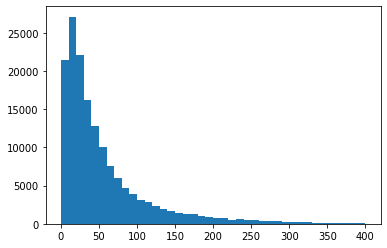

In [31]:
plt.hist(totalNumWords,bins = np.arange(0,410,10))#[0,50,100,150,200,250,300,350,400])#,450,500,550,600,650,700,750,800,850,900])
plt.show()

대부분의 문장길이는 30. 

# build Model

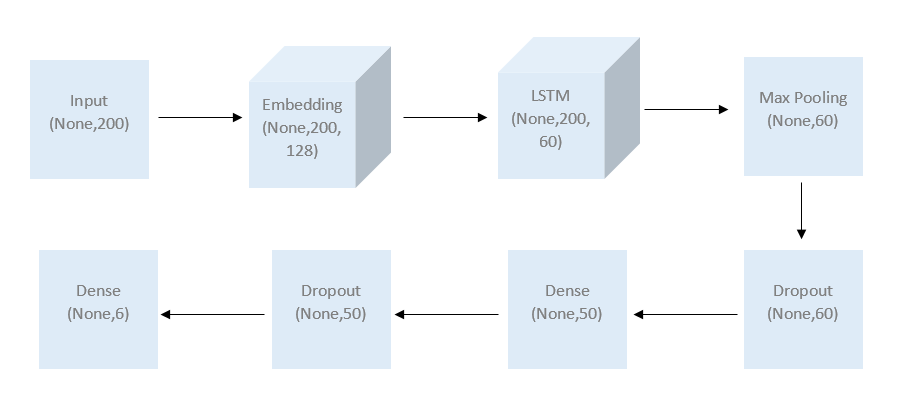

We begin our defining an Input layer that accepts a list of sentences that has a dimension of 200.

input은 dimension of 200.

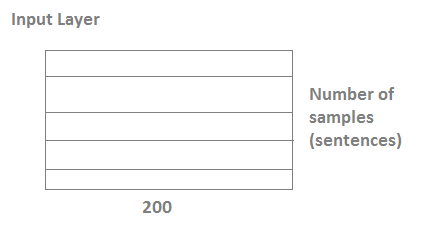

쉼표 뒤에 빈 공간을 표시하면 Keras가 숫자를 자동으로 설정하도록 지시

In [32]:
inp = Input(shape=(maxlen, )) #maxlen=200 as defined earlier

In [33]:
inp

<KerasTensor: shape=(None, 200) dtype=float32 (created by layer 'input_1')>

Embedding layer에 전달

문장에서 주변단어의 거리에 따라 정의된 벡터 공간에 단어를 투영

Embedding을 통해 얻을 수 있는 것.
- reduce model size
- huge dimenstions
  - one-hot encoding

Word Embedding의 역할
- Sparse representation -> Dense representation

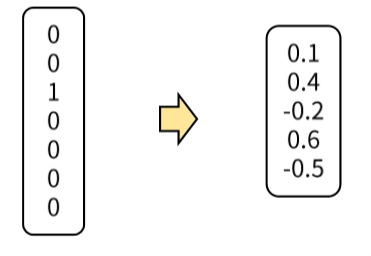

size of the ector space and number of uniqe word(max_features)의 정의가 필요

조정하고 실험할 수 있는 매개변수

In [34]:
embed_size = 128 
x = Embedding(max_features, embed_size)(inp)

Embedding layer (None, 200, 128)의  3-D tensor를 output

이것은 문장의 배열(None은 크기가 유추됨을 의미함)이며 각 단어(200)에 대해 임베딩의 벡터 공간에 128 coordinate의 배열이 있습니다

LSTM에 공급

차원이 60인 출력을 생성하도록 LSTM을 설정하고 풀린 결과의 전체 시퀀스를 반환하기를 원합니다.

LSTM 또는 RNN은 이전 네트워크의 출력을 현재 네트워크의 입력에 재귀적으로 공급하여 작동하며 X번의 재귀 후에 최종 출력을 가져옵니다.

그러나 사용 사례에 따라 다음 계층으로 전달할 결과로 전개되거나 각 재귀의 출력을 가져오고 싶을 수 있습니다.

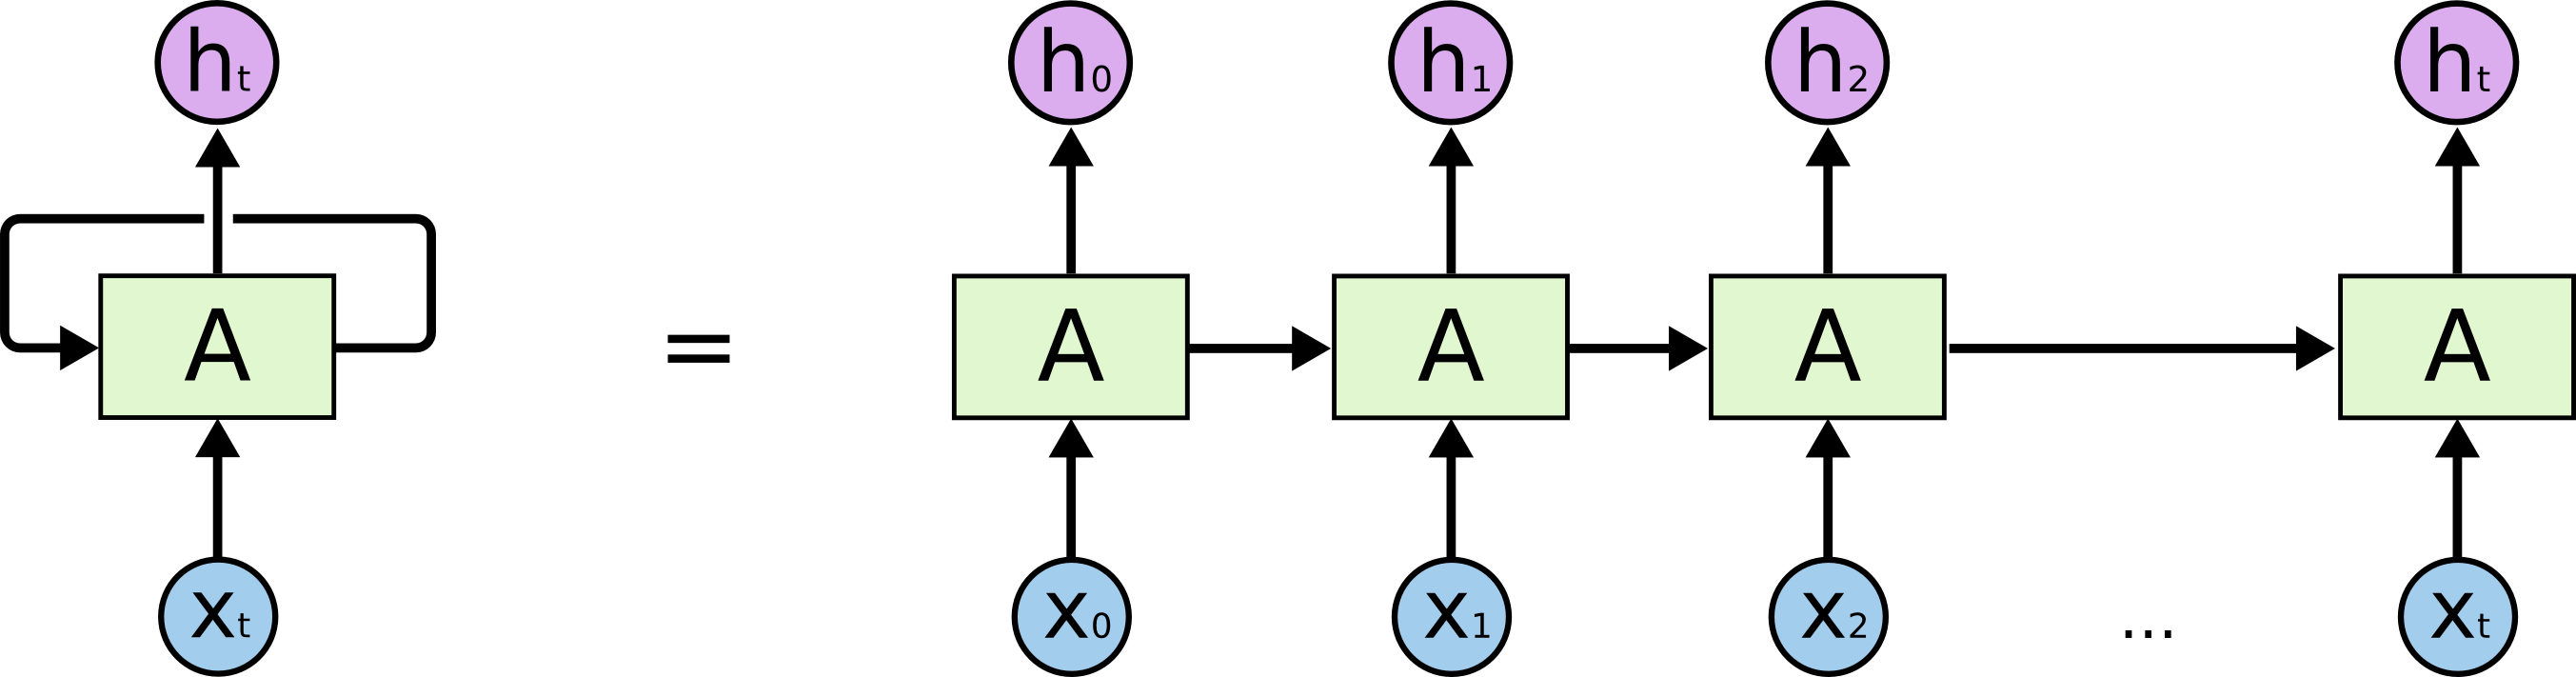

위의 그림에서 풀린 LSTM은 마지막 h까지 h0,h1,h2 세트를 제공합니다.

LSTM 계층을 정의하는 짧은 코드 줄에서 필요한 입력 demensions를 놓치기 쉽습니다.

LSTM은 [Batch Size, Time Steps, Number of Inputs]의 텐서를 사용합니다.

batch size는 number of samples이고,  time step는 각 입력에 대해 실행되는 재귀 횟수입니다. 또는 위 그림에서 "A"의 수로 나타낼 수 있습니다.

마지막으로 number of inputs는 위의 "x" 그림과 같이 LSTM에 전달하는 변수의 수(이 경우 각 문장의 단어 수)입니다.

(None, 200, 128)의 3-D tensor를 LSTM 레이어로 출력하는 이전 임베딩 레이어의 출력을 사용할 수 있습니다.

그것이 하는 일은 샘플을 살펴보고 LSTM을 200번 반복적으로 실행하고 매번 단어의 좌표를 전달하는 것입니다.

그리고 우리는 펼쳐진 버전(unrolled version)을 원하기 때문에 (None, 200, 60)의 Tensor 모양을 받게 됩니다. 여기서 60은 우리가 정의한 output dimension입니다.

In [36]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)


output을 일반 레이어로 전달하기 전에 3D 텐서를 2D로 reshape해야 합니다. 우리는 우리에게 중요한 데이터를 버리지 않도록 신중하게 재구성하며 이상적으로는 결과 데이터가 원본 데이터를 잘 대표하기를 원합니다.

따라서 이미지 데이터의 차원을 줄이기 위해 CNN 문제에서 전통적으로 사용되는 Global Max Pooling 레이어를 사용합니다. 간단히 말해서 데이터의 각 패치를 살펴보고 각 패치의 최대값을 취합니다. 이러한 최대값 컬렉션은 우리가 사용할 수 있는 축소된 데이터의 새로운 집합이 될 것입니다.

다른 Kaggle 커널에서 볼 수 있듯이 pooling layers의 different variants(Average, Max 등)이 차원 축소에 사용되며 다른 결과를 얻을 수 있으므로 시도해 보십시오.

In [37]:
x = GlobalMaxPool1D()(x)

2D Tensor를 손에 들고 일부 노드를 무차별적으로 "비활성화"하는 Dropout 레이어로 전달하여 다음 레이어의 노드가 누락된 데이터의 표현을 처리하도록 하고 전체 네트워크가 더 나은 일반화를 초래할 수 있습니다.

노드의 10%(0.1)를 드롭아웃하도록 드롭아웃 레이어를 설정했습니다.

In [38]:
x = Dropout(0.1)(x)

드롭아웃 레이어 이후에 드롭아웃 레이어의 출력을 조밀하게 연결된 레이어에 연결하고 출력은 RELU 함수를 통과합니다. 간단히 말해서 다음과 같습니다.

Activation( (Input X Weights) + Bias)

가중치, 바이어스 및 활성화 레이어가 모두 설정되어 있는 한 줄에 모두 포함되어 있습니다! Dense 레이어를 정의하여 50의 출력 차원을 생성했습니다.

In [39]:
x = Dense(50, activation="relu")(x)

출력을 Dropout 레이어에 다시 공급합니다.

마지막으로 출력을 Sigmoid 레이어에 공급합니다. 시그모이드가 사용되는 이유는 6개의 레이블 각각에 대해 이진 분류(1,0)를 달성하려고 하고 시그모이드 함수가 0과 1의 경계 사이에서 출력을 스쿼시하기 때문입니다.

In [40]:
x = Dense(6, activation="sigmoid")(x)

이제 입력, 출력을 정의하고 학습 프로세스를 구성하기만 하면 됩니다. 우리는 이진 분류를 다루기 때문에 Adam 옵티마이저를 사용하여 손실 함수를 최적화하도록 모델을 설정하고 손실 함수를 "binary_crossentropy"로 정의합니다. 학습률을 구하는 경우 기본값은 0.001로 설정됩니다.

In [41]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

각 배치에 대해 32개의 padded 되고 Indexing된 sentence 목록을 제공하고 데이터의 10%를 유효성 validation set로 분할합니다.

이 validation set는 각 배치에 대해 모델이 overfitted 되었는지 여부를 평가하는 데 사용됩니다.

모델은 2 Epoch 동안에도 실행됩니다. 다음은 실험할 수 있는 몇 가지 조정 가능한 매개변수로, model을 손상시키지 않고(따라서 배치 크기) 정확도를 다음 수준으로 높일 수 있는지 확인합니다.

In [42]:
batch_size = 32
epochs = 2
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/2
4488/4488 [==============================] - 360s 80ms/step - loss: 0.0720 - accuracy: 0.9809 - val_loss: 0.0511 - val_accuracy: 0.9940
Epoch 2/2
4488/4488 [==============================] - 356s 79ms/step - loss: 0.0464 - accuracy: 0.9930 - val_loss: 0.0481 - val_accuracy: 0.9939


In [43]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
lstm_layer (LSTM)            (None, 200, 60)           45360     
_________________________________________________________________
global_max_pooling1d (Global (None, 60)                0         
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3050      
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [66]:
list_sentences_train[0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [54]:
result = model.predict(X_t)

In [74]:
result[2]

array([2.6330352e-03, 6.7009746e-06, 1.9565225e-04, 4.2242067e-05,
       1.7327070e-04, 1.1433282e-04], dtype=float32)

# 참고

- keras Tokenizer  :https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
- keras Tokenizer 설명글 : https://han-py.tistory.com/284
- RNN 설명 블로그 : https://medium.com/humanscape-tech/rnn-recurrent-neural-network-%EC%88%9C%ED%99%98%EC%8B%A0%EA%B2%BD%EB%A7%9D-%EC%9D%84-%EC%9D%B4%ED%95%B4%ED%95%B4%EB%B3%B4%EC%9E%90-1697a5472af2
- LSTM 설명 : https://dgkim5360.tistory.com/entry/understanding-long-short-term-memory-lstm-kr
- LSTM 레츠고블로그: https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/
- Embedding의 역할 : https://simpling.tistory.com/entry/Embedding-%EC%9D%B4%EB%9E%80-%EB%AC%B4%EC%97%87%EC%9D%B8%EA%B0%80-%EC%9D%B4%ED%95%B4%ED%95%98%EA%B8%B0
- cs231n pooling Layer : https://cs231n.github.io/convolutional-networks/#pool